<a href="https://colab.research.google.com/github/XiangxiangXu/dnn_symmetry/blob/main/dnn_symmetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 [==============================] - 0s 53ms/step


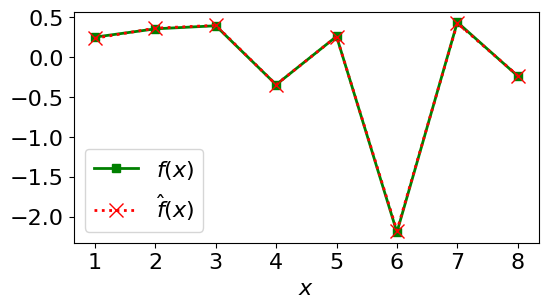

In [1]:
# -*- coding: utf-8 -*-
"""
Symmetry in NN
"""
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from sklearn.preprocessing import OneHotEncoder
#plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.ion()


def GenerateDiscreteSamples(Pxy, nSamples):
    '''
    generate n samples of (X, Y) pairs, with distribution Pxy

    return a list of two np.array(dtype=int), each of size n
    values in range(cX) and range(cY)

    as i.i.d. sample of (X,Y) pairs with joint distribution randomly chosen
    Input:    Pxy, a cY x cX matrix

    '''
    (yCard, xCard) = Pxy.shape
    PxyVec = Pxy.reshape(-1)  # PxyVec is the PMF of key = Y * cX + X
    key = np.random.choice(range(xCard*yCard), nSamples, p=PxyVec)
    """
    key = Y * cX + X, Pxy[Y, X] = PxyVec[Y * cX + X], shown as follows:

    [[       0,            1,  ...,            cX-1],
     [      cX,       cX + 1,  ...,       cX + cX-1],
     [     2cX,      2cX + 1,  ...,      2cX + cX-1],
            |          |       ...,          |
     [(cY-1)cX, (cY-1)cX + 1,  ..., (cY-1)cX + cX-1]]

    """
    Y = (key / xCard).astype(int)
    X = (key % xCard)

    return([X, Y])


xCard = 8
yCard = 6
k = 1  # k = 1 so you don't need to rotate the features f and g.
# only a scaling is required

nSamples = 100000  # This would not break the symmetry

# randomly pick a joint distribution, normalize
Pxy = np.random.random([yCard, xCard])
Pxy = Pxy / sum(sum(Pxy))

# compute marginals
Px = np.sum(Pxy, axis = 0)
Py = np.sum(Pxy, axis = 1)

[X, Y] = GenerateDiscreteSamples(Pxy, nSamples)

# one-hot encodings:
XLabels = np.eye(xCard)[X]
YLabels = np.eye(yCard)[Y]

'''Get feature f and weight g in neural network (Using XLabels to predict YLabels)'''
batch_size = 128
epochs = 30

model = Sequential()
model.add(Dense(k, input_dim=xCard))
model.add(Dense(yCard, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(XLabels,
          YLabels,
          verbose=0,
          batch_size=batch_size,
          epochs=epochs)

f = Model(inputs=model.input,
          outputs=model.layers[0].output).predict(np.eye(xCard))
g = model.get_weights()[2] # g is a k X |Y| matrix

rmodel = Sequential()
rmodel.add(Dense(xCard, input_dim = k, activation='softmax'))
rmodel.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
gy_samples = np.matmul(YLabels, g.T)

rmodel.fit(gy_samples,
           XLabels,
           verbose=0,
           batch_size=batch_size,
           epochs=epochs)

f_hat = rmodel.get_weights()[0]
f = f.reshape(-1)
f = f - np.dot(Px, f)
f_hat = f_hat.reshape(-1)
f_hat = f_hat - np.dot(Px, f_hat) # center the variable, subtract the mean

# we should expect exactly matching between f and f_hat

plt.figure(figsize = (6, 3))
plt.plot(np.arange(1, xCard + 1), f, 'gs-', label = '$f(x)$', linewidth = 2, markersize = 6)
plt.plot(np.arange(1, xCard + 1), f_hat, 'rx:', label = '$\hat{f}(x)$', linewidth = 2, markersize = 10)
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('$x$', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.draw()

